# Exploración de la data

In [1]:
# importamos las librerías a utilizar
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance

## Configuracion de las rutas para lograr las importaciones

In [2]:
import sys
import os

# obtiene la ruta absoluta del directorio 'src' desde la ubicación del notebook
src_path = os.path.abspath(os.path.join('..', 'src'))

# agrega la ruta a 'src' al sys.path si no está ya presente
if src_path not in sys.path:
    sys.path.append(src_path)

## Cargamos los datos

In [3]:
from utils import load_data, ReadCsvParams, SaveCsvParams

file_path = '../data/raw/hotel_booking.csv'
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
read_csv_params: ReadCsvParams = {'delimiter': ','}
save_csv_params: SaveCsvParams = {'sep': ','}

df_hotel: pd.DataFrame = load_data(
    file_path=file_path, url=url, read_csv_params=read_csv_params, save_csv_params=save_csv_params
)

Loading data from file: ../data/raw/hotel_booking.csv


Ahora procedemos a ver la información general de los datos

In [4]:
# Mostramos para chequear
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,03/07/2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [5]:
# Mostramos información básica
df_hotel.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [6]:
# Mostramos información básica
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Eliminamos la data a no utilizar

Eliminaremos las siguientes columnas ya que es data que no apoyara al modelo.

In [7]:
# Eliminamos columnas que no aportan
columnas_a_eliminar = ['name', 'email', 'phone-number', 'credit_card', 'company', 'reservation_status', 'reservation_status_date', 'agent']
df_hotel.drop(columns=columnas_a_eliminar, inplace=True)

In [8]:
print("\nColumnas luego de eliminar las que no sirven:")
pd.DataFrame(df_hotel.columns, columns=['Columnas eliminadas'])


Columnas luego de eliminar las que no sirven:


,Columnas eliminadas
0,hotel
1,is_canceled
2,lead_time
3,arrival_date_year
4,arrival_date_month
5,arrival_date_week_number
6,arrival_date_day_of_month
7,stays_in_weekend_nights
8,stays_in_week_nights
9,adults


## Eliminamos los valores nulos

Estudiamos los valores nulos para cada columna.

In [9]:
# Ahora analizamos los valores nulos
print("\nCantidad de valores nulos por columna:")
cantidad_nulos = pd.DataFrame(df_hotel.isnull().sum(), columns=['Cantidad de nulos'])
cantidad_nulos[cantidad_nulos['Cantidad de nulos'] > 0]


Cantidad de valores nulos por columna:


,Cantidad de nulos
children,4
country,488


In [10]:
# Para ver también en porcentaje (opcional)
print("\nPorcentaje de valores nulos por columna:")
porcentaje_nulos = pd.DataFrame((df_hotel.isnull().sum() / len(df_hotel)) * 100, columns=['Porcentaje de nulos'])
porcentaje_nulos = porcentaje_nulos[porcentaje_nulos['Porcentaje de nulos'] > 0].map(lambda x: f'{x:.3f}%')
porcentaje_nulos


Porcentaje de valores nulos por columna:


,Porcentaje de nulos
children,0.003%
country,0.409%


## Columnas sobre las que trabajar y sus tipo

Guardamos las columnas de cada tipo para poder trabajar mas fácil

In [11]:
# variable objetivo
target: str = 'is_canceled'

# columnas numéricas
col_numericas: list[str] = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

# columnas categoricas
col_categoricas: list[str] = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# features
features = col_numericas + col_categoricas

# agrega a las columnas categoricas la variable objetivo
col_categoricas = col_categoricas + [target]

## Graficos De Análisis

### Analisis de la variable objetivo

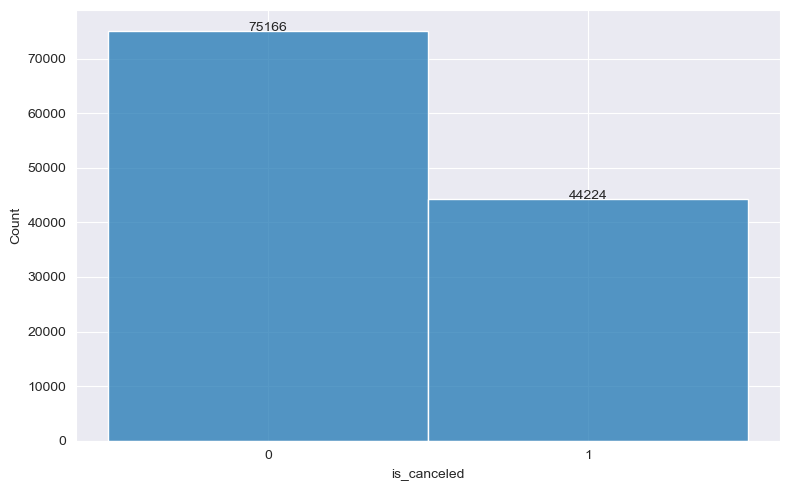

In [12]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5))

# graph the amount of each label
ax = sns.histplot(data=df_hotel, x="is_canceled", discrete=True)


# add the value of each bin on top of the bar
for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=p.get_height() + 0.1,
        s=f'{int(p.get_height())}',
        ha='center'
    )

# set the x-axis ticks to 0 and 1
plt.xticks([0, 1])

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()

Donde 0 es que la reserva no fue cancelada y 1 es que la reserva fue cancelada. Podemos ver que la data está desbalanceada, con mayor cantidad de data para los labels 0 (reservas no canceladas).

### Analisis de la variable objetivo contra las features(target)

Estudiamos la relación de la variable objetivo con las demás variables

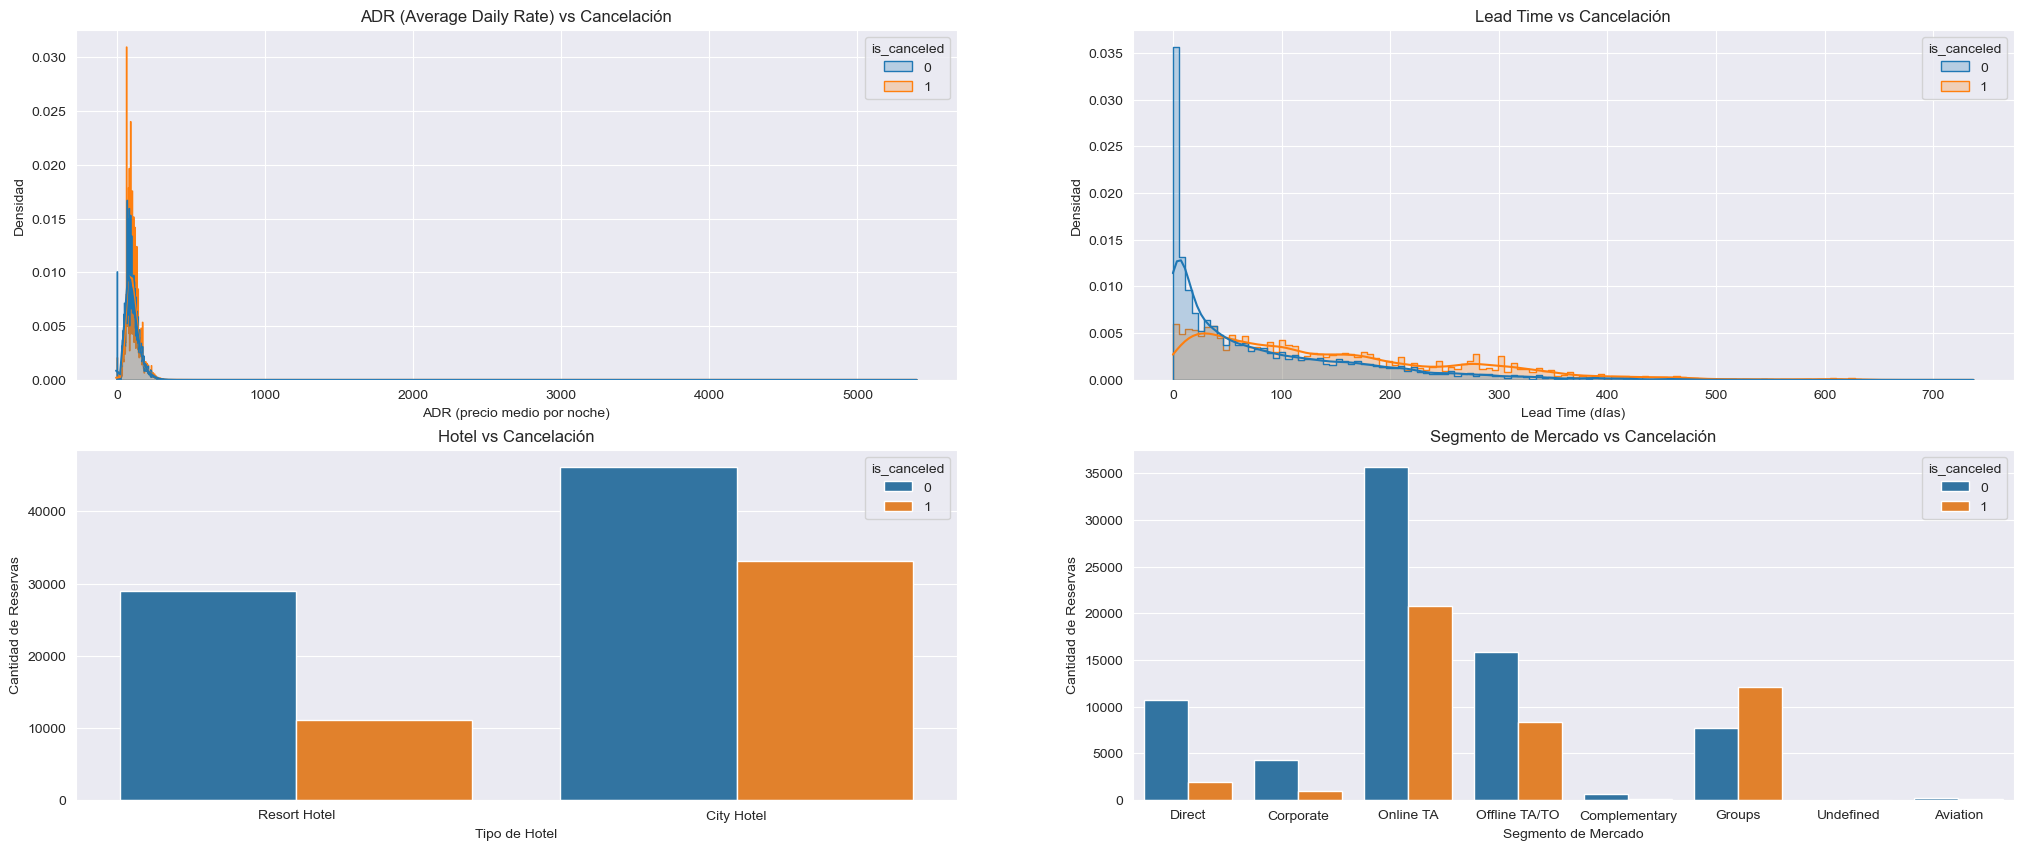

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

_, axis = plt.subplots(2, 2, figsize=(25, 10))

# 1. adr vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='adr', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 0]).set(
    title='ADR (Average Daily Rate) vs Cancelación',
    xlabel='ADR (precio medio por noche)',
    ylabel='Densidad',
)
# plt.xlim(0, 500)  # Limitar para que los outliers extremos no deformen el gráfico
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 2. lead_time vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='lead_time', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 1]).set(
    title='Lead Time vs Cancelación',
    xlabel='Lead Time (días)',
    ylabel='Densidad',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 3. hotel vs. cancelación
sns.countplot(data=df_hotel, x='hotel', hue='is_canceled', ax=axis[1, 0]).set(
    title='Hotel vs Cancelación',
    xlabel='Tipo de Hotel',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 4. market_segment vs. cancelación
sns.countplot(data=df_hotel, x='market_segment', hue='is_canceled', ax=axis[1, 1]).set(
    title='Segmento de Mercado vs Cancelación',
    xlabel='Segmento de Mercado',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])
# plt.xticks(rotation=45)

plt.show()

### Matriz de correlación entre las variables numéricas

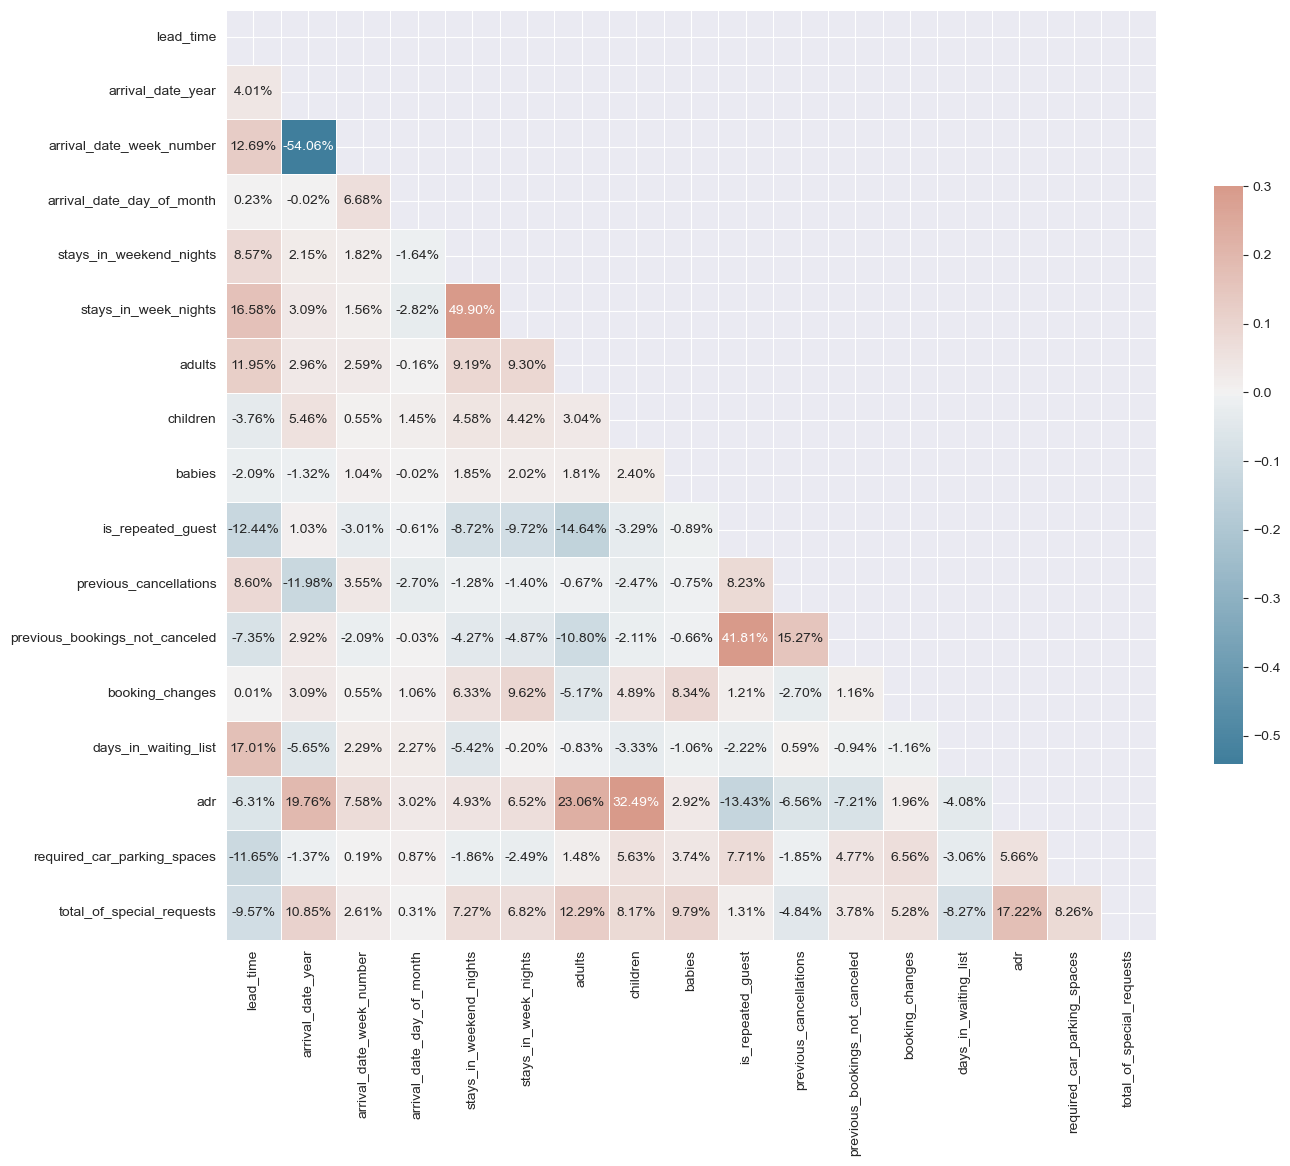

In [14]:
from draw_utils import draw_corr_matrix


# crea la matriz de correlación de las variables numericas
corr = df_hotel[col_numericas].corr()

# dibuja la matriz de correlación
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlación entre las variables categoricas

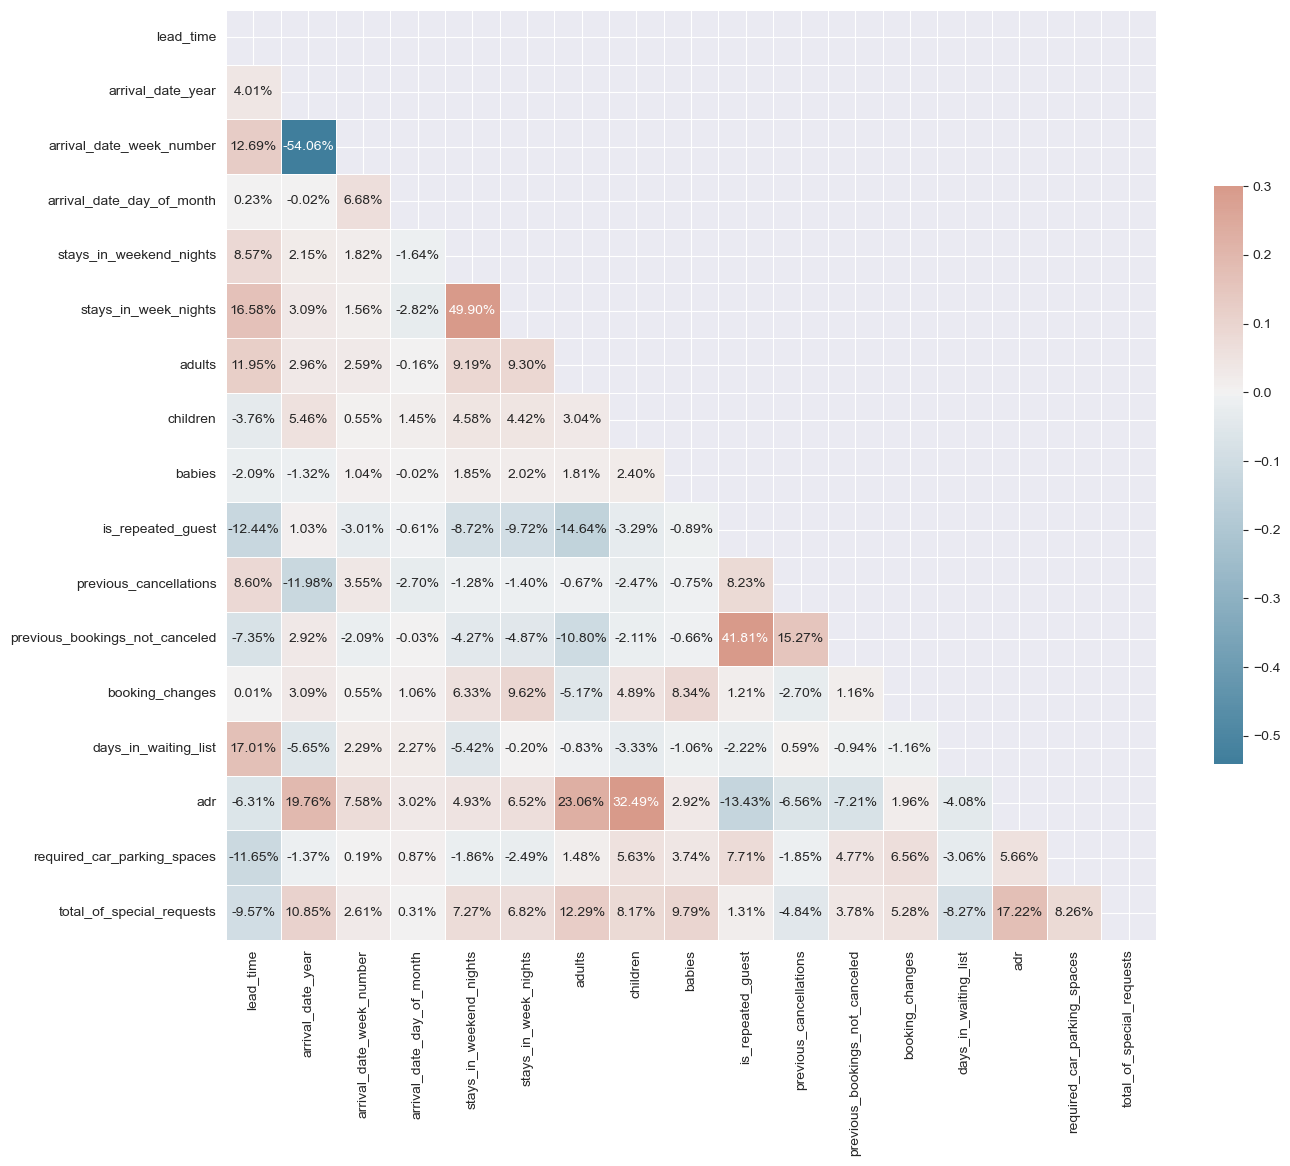

In [15]:
from sklearn.preprocessing import LabelEncoder


# convertimos las variables categóricas a numéricas usando sklearn
df_hotel_encoded = df_hotel.copy()
label_encoders = {}

for column in col_categoricas:
    # crea el decoder
    le = LabelEncoder()

    # hacemos ajuste y trasformación de la columna
    df_hotel_encoded[column] = le.fit_transform(df_hotel[column])

    # guardamos el encoder por si luego queremos invertir
    label_encoders[column] = le

# crea la matriz de correlacion de las variables categoricas
corr = df_hotel_encoded[col_numericas].corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlacion completa de todas las variables

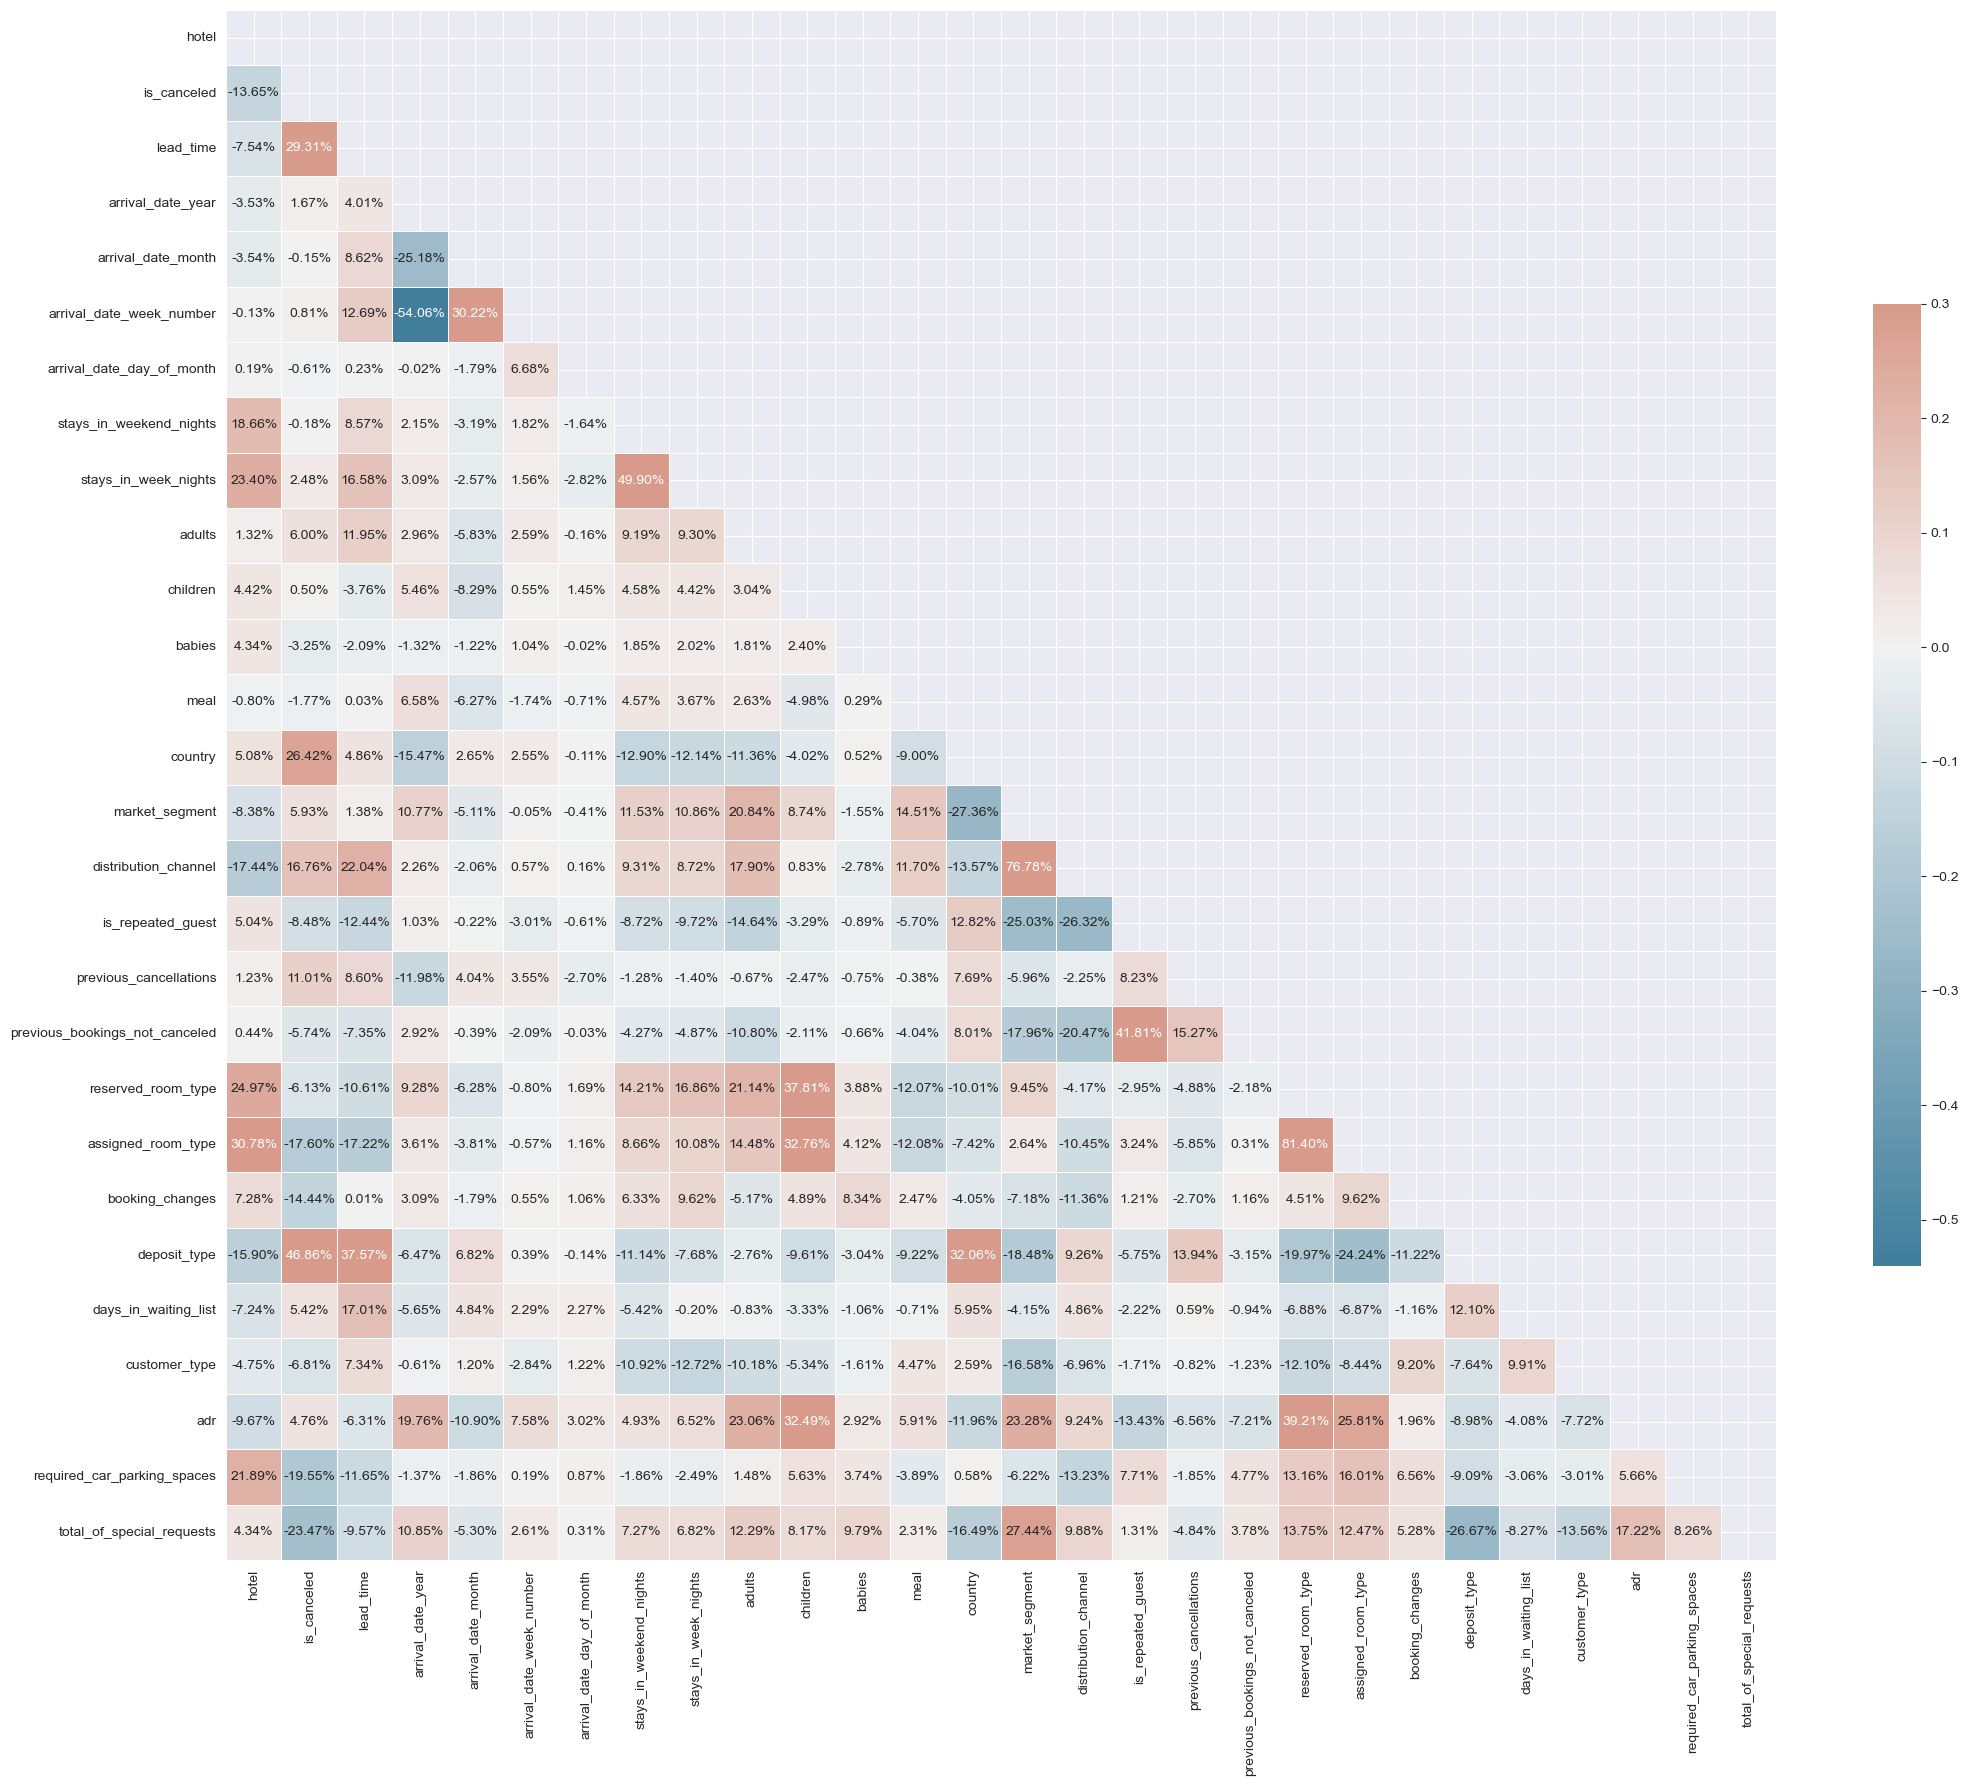

In [16]:
# crea la matriz de correlación de todas las variables
corr = df_hotel_encoded.corr()

# dibuja la matriz de correlación
draw_corr_matrix(corr=corr, fig_size=(25, 25))

A traves de estas matrices podemos hacer un analisis inicial, pero las decisiones sobre qué variables tomar y sacar se hara más adelante en el analisis del modelo.

## Guardamos los datos pre-procesados

In [17]:
# definimos la ruta
ruta_pre_procesado = '../data/processed/hotel_booking.csv'
try:
    # save the DataFrame to the file for future use
    df_hotel_encoded.to_csv(ruta_pre_procesado, index=False, sep=save_csv_params["sep"])

    print(f"Data saved to file: {ruta_pre_procesado}")

except Exception as e:
    print(f"Error saving data to {ruta_pre_procesado} with error: {e}")

Data saved to file: ../data/processed/hotel_booking.csv


# Estudio de un modelo básico

Vamos a hacer un análisis de un modelo básico para verificar que la elección del mismo puede dar solución al problema.

## Separamos los datos en entrenamiento y prueba

In [18]:
from utils import split_my_data


# Toma las variables y el target
X = df_hotel_encoded.drop(columns=target)
y = df_hotel_encoded[target]

# divide the dataset into training and test samples
X_train, X_test, y_train, y_test = split_my_data(X, y, test_size=0.2, random_state=42)

## Entrenamiento del modelo XGBoost

In [19]:
import xgboost as xgb


# Inicializamos el modelo
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Entrenamiento
model.fit(X_train, y_train)

F:\SoftwareInstalls\Anaconda\envs\ds_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:55:46] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluación del modelo

In [20]:
# Predicciones y evaluación
y_pred = model.predict(X_test)

In [21]:
y_proba = model.predict_proba(X_test)[:, 1]

### Matriz de confusion


Matriz de confusion:


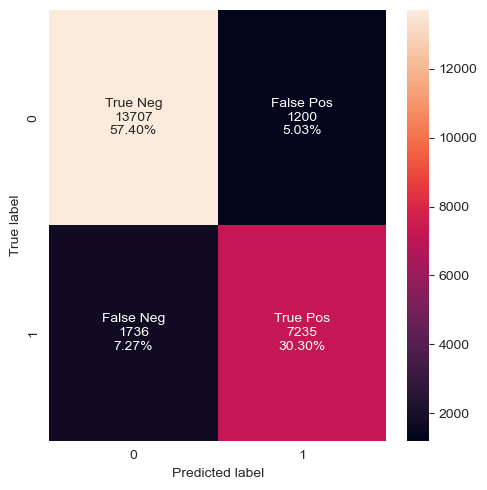

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from draw_utils import draw_confusion_matrix


# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusion:")
draw_confusion_matrix(conf_matrix)


Interpretación rápida:

- True Neg  **(13713)** → Reservas no canceladas predichas correctamente.
- True Pos  **(7237)** → Cancelaciones correctamente detectadas.
- False Pos **(1194)** → Predijo cancelación, pero la reserva no fue cancelada.
- False Neg **(1734)** → No predijo cancelación, pero sí se canceló.

Con base en estos números, el modelo está haciendo un trabajo razonable, pero hay margen de mejora en los falsos negativos si nuestro objetivo es minimizar el **churn** (posibilidad de que alguien siga con el servicio).

### Metrica ROC AUC

Hacemos el estudio de la metrica ROC AUC para verificar el desempeno del modelo. Se sekecciona esta metrica para el estudio debido a que la data se encuentra desbalanceada.

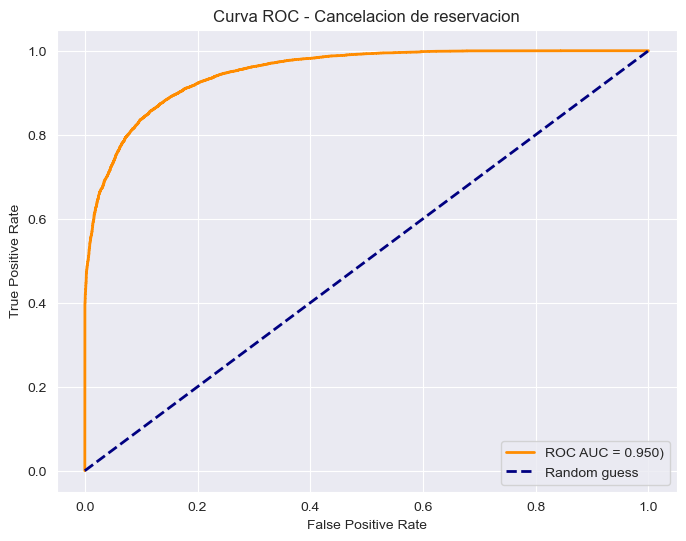

In [23]:
from draw_utils import draw_roc_auc


draw_roc_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

### Seleccion del mejor punto de corte

Para este valor de Auc Roc estudiamos los puntos de corte donde mejor F1-score obtengamos

In [24]:
# F1 Score por cuantiles
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
# construimos los thresholds a estudiar
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9))
scores = []

for t in thresholds:
    # realizamos la prediccion de forma manual con base en
    # las probabilidades que se obtienen del modelo
    pred = (df_eval['proba'] >= t).astype(int)

    #calculamos el f1-score
    f1 = f1_score(df_eval['true'], pred)

    # guardamos el score
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.00 | F1 Score: 0.589
Threshold: 0.00 | F1 Score: 0.597
Threshold: 0.00 | F1 Score: 0.604
Threshold: 0.00 | F1 Score: 0.612
Threshold: 0.00 | F1 Score: 0.621
Threshold: 0.01 | F1 Score: 0.629
Threshold: 0.01 | F1 Score: 0.638
Threshold: 0.01 | F1 Score: 0.646
Threshold: 0.02 | F1 Score: 0.655
Threshold: 0.02 | F1 Score: 0.664
Threshold: 0.03 | F1 Score: 0.673
Threshold: 0.03 | F1 Score: 0.682
Threshold: 0.04 | F1 Score: 0.692
Threshold: 0.05 | F1 Score: 0.702
Threshold: 0.06 | F1 Score: 0.711
Threshold: 0.07 | F1 Score: 0.721
Threshold: 0.08 | F1 Score: 0.730
Threshold: 0.09 | F1 Score: 0.740
Threshold: 0.11 | F1 Score: 0.750
Threshold: 0.12 | F1 Score: 0.760
Threshold: 0.14 | F1 Score: 0.769
Threshold: 0.16 | F1 Score: 0.777
Threshold: 0.18 | F1 Score: 0.786
Threshold: 0.20 | F1 Score: 0.795
Threshold: 0.22 | F1 Score: 0.804
Threshold: 0.24 | F1 Score: 0.810
Threshold: 0.27 | F1 Score: 0.817
Threshold: 0.29 | F1 Score: 0.8

In [25]:
# seleccionamos el mejor threshold
best_threshold = max(scores, key=lambda x: x[1])[0]

# realizamos las predicciones con este nuevo threshold de clasificacion
y_pred = (y_proba >= best_threshold).astype(int)

print(f"\n✅ Mejor threshold (F1): {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"AUC (el mismo valor visto en la grafica anterior): {roc_auc_score(y_test, y_proba):.3f}")


✅ Mejor threshold (F1): 0.41
F1 Score: 0.835
AUC (el mismo valor visto en la grafica anterior): 0.950



Matriz de confusion:


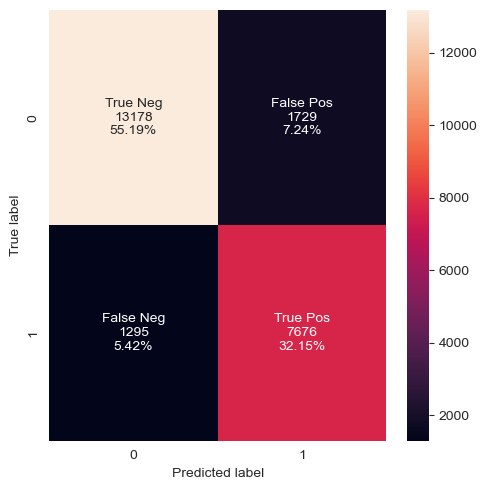

In [26]:
# matriz de confusión con el nuevo threshold
conf_matrix_with_opt_f1_score = confusion_matrix(y_test, y_pred)

print("\nMatriz de confusion:")

draw_confusion_matrix(conf_matrix_with_opt_f1_score)

Comparamos ambas matrices de confusion, la original y la neuva con el metodo

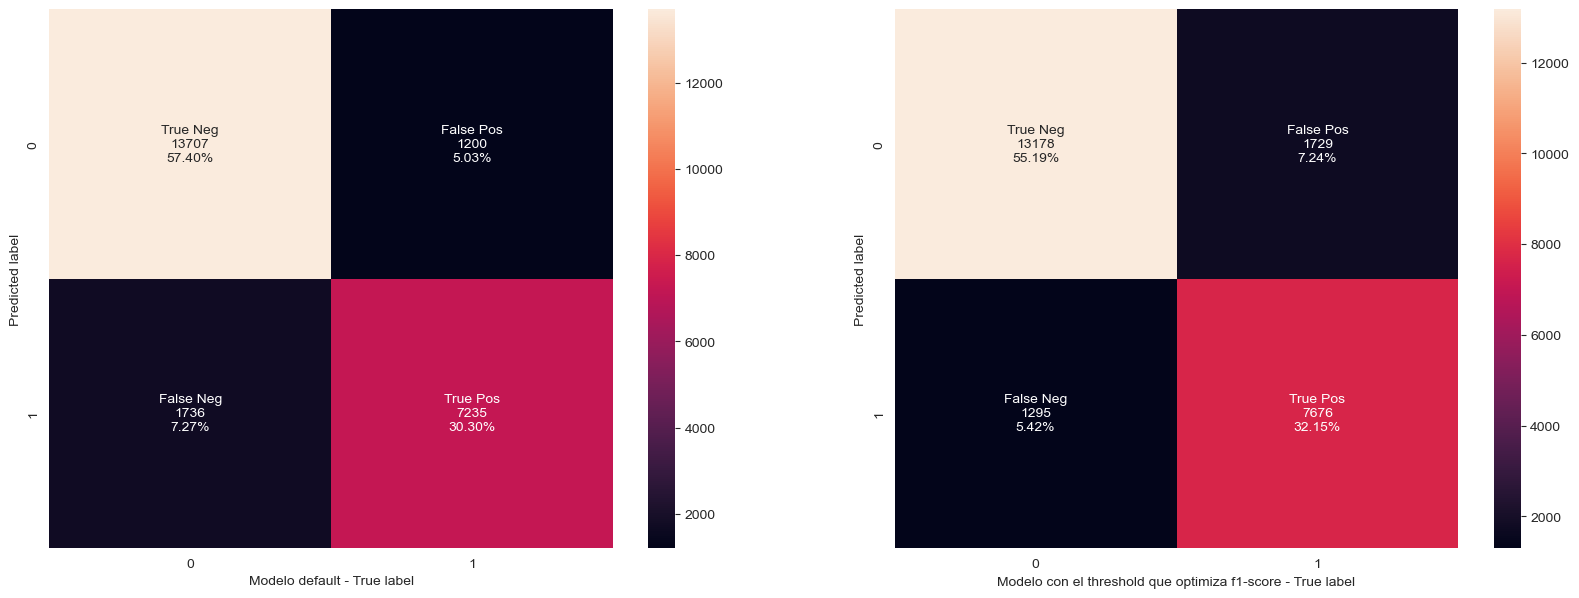

<Figure size 1000x500 with 0 Axes>

In [27]:
from src.draw_utils import draw_comparison_confusion_matrices

draw_comparison_confusion_matrices(
    confusion_1=conf_matrix,
    confusion_2=conf_matrix_with_opt_f1_score,
    confusion_matrix_1_name='Modelo default',
    confusion_matrix_2_name='Modelo con el threshold que optimiza f1-score'
)

Podemos obsevar que con el nuevo threshold se tiene un mejor desempeno con los falsos postivos, valores extremadamente importantes para el modelo. Por lo tanto es mejor utilizar el mdoelo con el threshold encotnrado que maximisa el f1-score.

### Grafico precision - recall

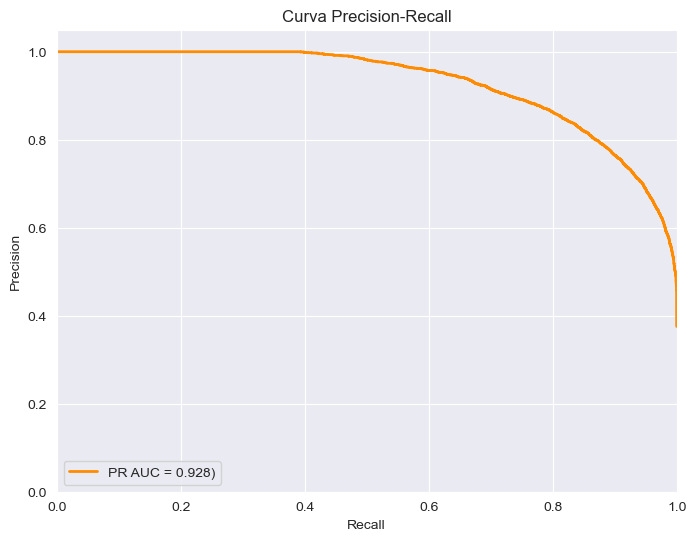

In [28]:
from draw_utils import draw_pr_auc


draw_pr_auc(
    y_test=y_test,
    y_prob=y_proba,
    g_title='Curva ROC - Cancelacion de reservacion'
)

Podemos observar que nuestro modelo a tratar de mejorar el Recall disminuye la precision. Por lo tanto, al tratar de mejorar la capacidad del modelo de identificar las personas que cancelaran la capacida de identificar las personas que no cancelan disminuira.

### Interpretacion SHAP

 99%|===================| 23706/23878 [01:02<00:00]        

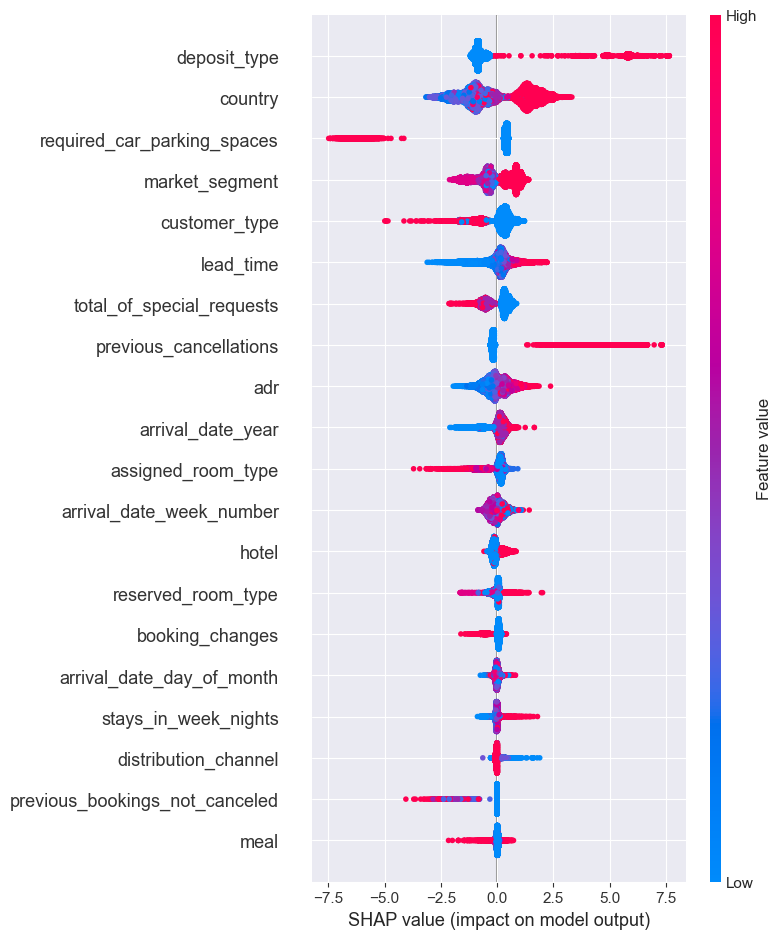

In [29]:
import shap

# interpretación SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

La variable con mas importancia que podemos ver en este gráfico (deposit_type), es la que tiene mas impacto en el modelo, es decir que los depositos que no se realizaron generan mas probabilidad de cancelación

In [30]:
# Métricas de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     14907
           1       0.82      0.86      0.84      8971

    accuracy                           0.87     23878
   macro avg       0.86      0.87      0.87     23878
weighted avg       0.88      0.87      0.87     23878



Podemos observar que el modelo posee buenas métricas con valores de precision, recall y f1-score cercanos por lo tanto parece no existir un alto overfitting.

## Estudio de la importancia de cada variable

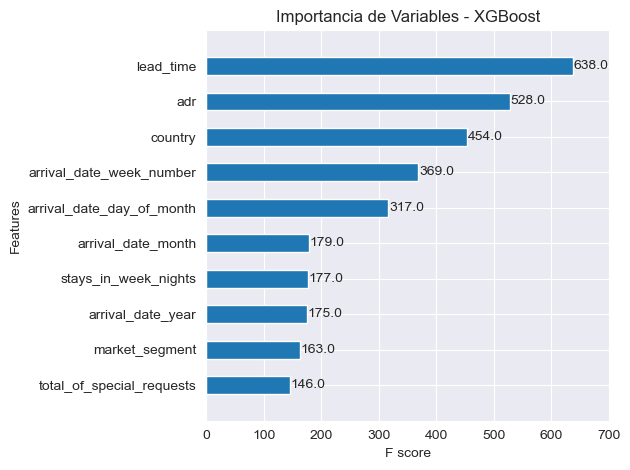

In [31]:
#Interpretación del modelo – Importancia de Variables
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Visualización de importancia de las características
plot_importance(model, max_num_features=10, height=0.5)
plt.title("Importancia de Variables - XGBoost")
plt.tight_layout()
plt.show()

## Interpretación de Importancia de Variables

Las top 3 variables que más influyen en la predicción de cancelaciones son:

1. lead_time (Tiempo entre reserva y llegada) → cuanto mayor, más riesgo de cancelación.
2. adr	(Precio medio por noche) → precios altos pueden ser más susceptibles a cancelación.
3. country	(Origen del huésped) → posiblemente refleja patrones culturales o restricciones.

In [32]:
# Crear DataFrame con importancias
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Ordenar por importancia descendente
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Mostrar tabla
feature_importances.reset_index(drop=True, inplace=True)
feature_importances.head(15)


,Feature,Importance
0,deposit_type,0.630273
1,required_car_parking_spaces,0.102176
2,previous_cancellations,0.044430
3,market_segment,0.033979
4,total_of_special_requests,0.028843
5,country,0.017775
6,customer_type,0.015534
7,previous_bookings_not_canceled,0.015099
8,arrival_date_year,0.013341
9,booking_changes,0.011626


Guardamos la gráfica de feature


In [33]:
# definimos la ruta
ruta_pre_procesado = '../data/processed/feature_importances.csv'
try:
    # save the DataFrame to the file for future use
    feature_importances.to_csv(ruta_pre_procesado, index=False, sep=save_csv_params["sep"])

    print(f"Data saved to file: {ruta_pre_procesado}")

except Exception as e:
    print(f"Error saving data to {ruta_pre_procesado} with error: {e}")

Data saved to file: ../data/processed/feature_importances.csv


 Hallazgos clave de la importancia de variables:

| Variable                   | Interpretación estratégica para churn |
|----------------------------|----------------------------------------|
| `deposit_type`             | La más influyente. Si no hay depósito, el cliente puede cancelar sin penalización. Esto **debería revisarse** como política de negocio. |
| `required_car_parking_spaces` | Clientes que requieren estacionamiento parecen más comprometidos con su estadía. |
| `previous_cancellations`  | Los que han cancelado antes, tienden a hacerlo de nuevo. Perfil de cliente riesgoso. |
| `market_segment`          | El canal de origen de la reserva afecta la tasa de cancelación. Canales online (OTA) suelen tener más cancelaciones. |
| `total_of_special_requests` | Clientes con solicitudes especiales tienden a ser más fieles. |

En cambio, variables como meal, distribution_channel, y assigned_room_type tienen bajo impacto predictivo en este modelo.

## Conclusiones del modelo de cancelación (churn) con XGBoost

**1. Variables más influyentes:**
- `deposit_type`: La política de depósito es el factor más determinante. Las reservas sin depósito tienen alta tasa de cancelación.
- `required_car_parking_spaces`: Los clientes que solicitan estacionamiento parecen estar más comprometidos.
- `previous_cancellations`: El historial del cliente predice comportamiento futuro: quienes ya cancelaron, lo harán de nuevo.

**2. Implicancias de negocio:**
- Reforzar políticas de depósito mínimo o penalización en segmentos con alta cancelación.
- Priorizar promociones hacia segmentos con baja propensión a cancelar (p.ej., quienes hacen solicitudes especiales).
- Evaluar y controlar canales de reserva con alto churn (p.ej., ciertos `market_segment` o `distribution_channel`).

**3. Recomendaciones adicionales:**
- Implementar alertas tempranas para reservas con alto `lead_time` y sin depósito.
- Ofrecer beneficios adicionales a clientes frecuentes que nunca han cancelado (`previous_bookings_not_canceled` alto).
- Reentrenar el modelo regularmente para adaptarse a cambios de comportamiento por estacionalidad o eventos externos.

---

✅ El modelo XGBoost ofrece una buena capacidad predictiva y guía acciones concretas para reducir la tasa de cancelaciones.
